<a href="https://colab.research.google.com/github/lolddong/data_analysis/blob/main/18_CNN_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN-CIFAR-10 이미지 분류 (다항분류)

## 1. 패키지 가져오기

In [1]:
import os
import helper
import zipfile

from PIL import Image
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. 데이터셋 준비하기
- 이미지에 대한 압축 파일을 구글 드라이브에 업로드 해 놓은 상태
### 1) 이미지 파일의 압축 해제

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 압축파일의 경로
file_path = '/content/drive/MyDrive/Colab Notebooks/CIFAR-10.zip'


# 압축을 해제할 경로
extract_dir = os.path.join(os.getcwd(), 'data')

# 해당 폴더가 없다면 폴더를 생성
if not os.path.exists(extract_dir):
  os.mkdir(extract_dir)

# 파일의 압축 해제
zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall(extract_dir)
zip_ref.close()

### 2) 임의의 이미지 확인
- 훈련용 이미지와 검증용 이미지가 따로 구분되어 있지 않다.
#### 각 폴더 안에서 임의의 이미지를 추출하여 확인

In [4]:
# 압축 해제된 폴더의 경로
base_dir = os.path.join(extract_dir, 'CIFAR-10')
print(base_dir)

# 훈련용 이미지 폴더
train_dir = os.path.join(base_dir, 'train')
print(train_dir)

# 검증용 이미지 폴더
test_dir = os.path.join(base_dir, 'test')
print(test_dir)

# 분류해야할 항목의 종류 -> 폴더의 종류
features = os.listdir(train_dir)
print(features)

/content/data/CIFAR-10
/content/data/CIFAR-10/train
/content/data/CIFAR-10/test
['dog', 'truck', 'bird', 'cat', 'automobile', 'airplane', 'horse', 'frog', 'deer', 'ship']


/content/data/CIFAR-10/train/dog
/content/data/CIFAR-10/train/truck
/content/data/CIFAR-10/train/bird
/content/data/CIFAR-10/train/cat
/content/data/CIFAR-10/train/automobile
/content/data/CIFAR-10/train/airplane
/content/data/CIFAR-10/train/horse
/content/data/CIFAR-10/train/frog
/content/data/CIFAR-10/train/deer
/content/data/CIFAR-10/train/ship


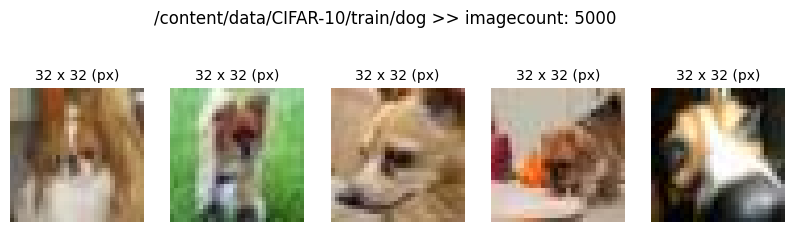

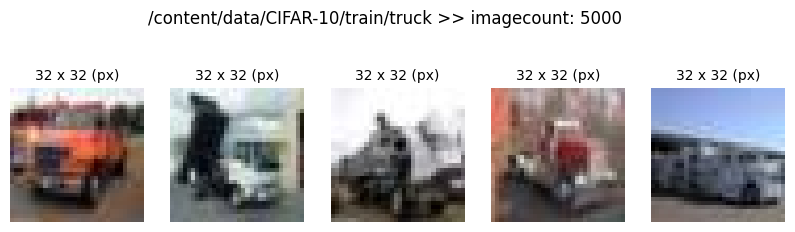

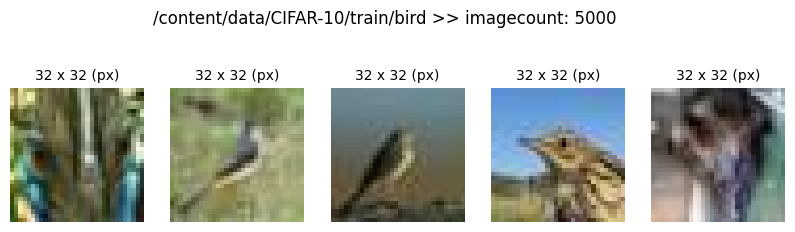

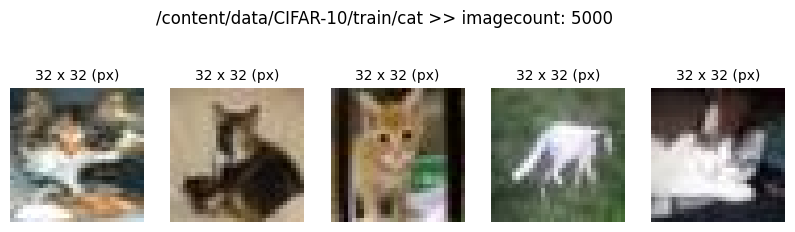

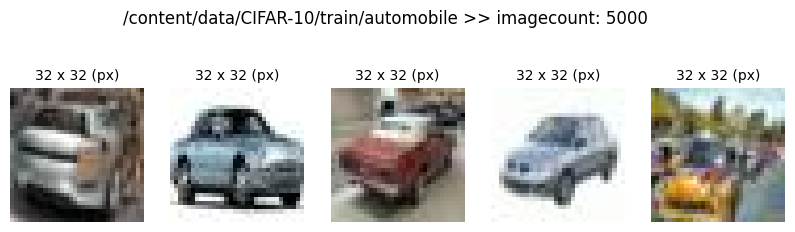

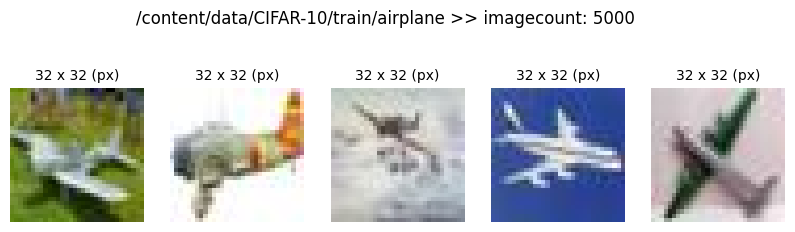

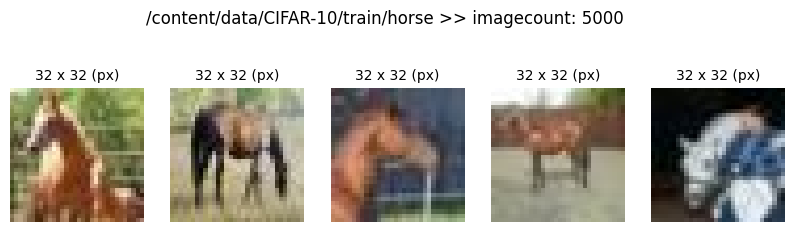

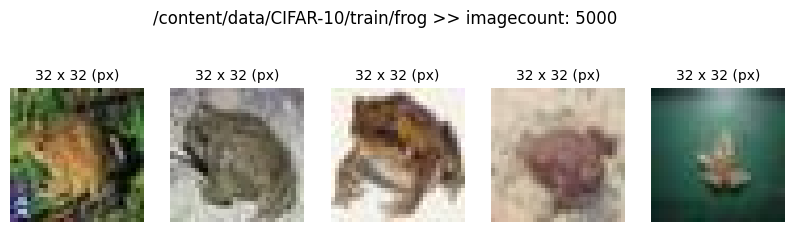

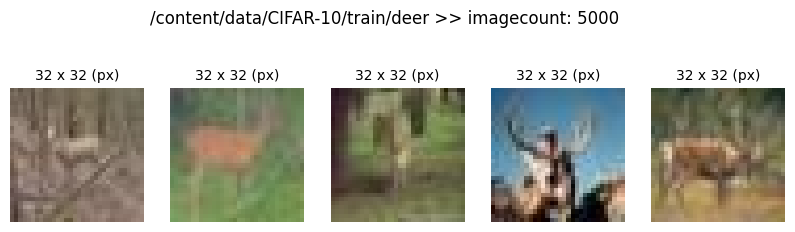

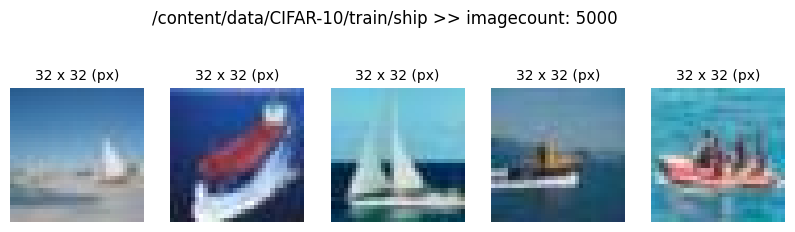

In [5]:
for j, w in enumerate(features):
  # 각 폴더 경로
  target_dir = os.path.join(train_dir, w)
  print(target_dir)

  # 각 폴더별로 파일의 목록을 가져옴
  file_list = os.listdir(target_dir)

  # 각 폴더별 파일의 수
  file_count = len(file_list)

  fig, ax = plt.subplots(1, 5, figsize = (10, 3))
  fig.suptitle('%s >> imagecount: %d' % (target_dir, file_count))

  for k, x in enumerate(ax):
    file_path = os.path.join(target_dir, file_list[k])
    sample = Image.open(file_path)
    x.set_title('%d x %d (px)' % (sample.size[0], sample.size[1]), fontsize = 10)
    x.imshow(sample)
    x.axis('off')
plt.show()
plt.close()

## 3. 데이터 전처리
### 1) 이미지 데이터 증강

In [6]:
train_datagen = ImageDataGenerator(rescale = 1.0/255)
test_datagen = ImageDataGenerator(rescale = 1.0/255)

train_set = train_datagen.flow_from_directory(train_dir,
                                              classes = features,
                                              batch_size = 5,
                                              class_mode = 'categorical',
                                              target_size = (32, 32))
test_set = test_datagen.flow_from_directory(test_dir,
                                            classes = features,
                                            batch_size = 5,
                                            class_mode = 'categorical',
                                            target_size = (32, 32))

len(train_set), len(test_set)

Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


(10000, 2000)

## 4. 모델 개발
### 1) 모델 정의

In [7]:
my_model = Sequential()

my_model.add(Conv2D(filters=16, kernel_size = 6, strides = 1, padding='same',
                    activation = 'relu', input_shape=(32, 32, 3)))
my_model.add(BatchNormalization())
my_model.add(MaxPool2D(pool_size = (2, 2), strides=(2,2)))
my_model.add(Dropout(0.25))

my_model.add(Conv2D(filters=32, kernel_size=5, strides=1, padding='same',
                    activation='relu'))
my_model.add(MaxPool2D(pool_size = (2, 2), strides=(2,2)))
my_model.add(Dropout(0.25))

my_model.add(Conv2D(filters=64, kernel_size = 4, strides=1, padding='same',
                    activation='relu'))
my_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
my_model.add(Dropout(0.25))

my_model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same',
                    activation='relu'))
my_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
my_model.add(Dropout(0.25))

my_model.add(Conv2D(filters=256, kernel_size=2, strides=(1,1), padding='same',
                    activation='relu'))
my_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
my_model.add(Dropout(0.25))

my_model.add(Flatten())
my_model.add(Dense(1024, activation='relu'))
my_model.add(Dense(10, activation='softmax'))

my_model.compile(optimizer='adam', loss='categorical_crossentropy',
                 metrics=['acc'])

my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        1744      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 16)        64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0

### 2) 학습하기

In [8]:
start = dt.datetime.now()

result = my_model.fit(train_set, epochs=500, validation_data = test_set,
                      callbacks=[EarlyStopping(monitor='val_loss',
                                               patience=5,
                                               verbose=1),
                                 ReduceLROnPlateau(monitor='val_loss',
                                                   patience=3,
                                                   factor=0.5,
                                                   min_lr=0.0001,
                                                   verbose=1)])
end = dt.datetime.now()
delta = end-start
'총 학습 소요시간: %d(초)' % delta.seconds

Epoch 1/500
10000/10000 [==============================] - 99s 9ms/step - loss: 1.8366 - acc: 0.3162 - val_loss: 1.5964 - val_acc: 0.4236 - lr: 0.0010
Epoch 2/500
10000/10000 [==============================] - 86s 9ms/step - loss: 1.6448 - acc: 0.3986 - val_loss: 1.6230 - val_acc: 0.4117 - lr: 0.0010
Epoch 3/500
10000/10000 [==============================] - 88s 9ms/step - loss: 1.5567 - acc: 0.4352 - val_loss: 1.4301 - val_acc: 0.4860 - lr: 0.0010
Epoch 4/500
10000/10000 [==============================] - 86s 9ms/step - loss: 1.4943 - acc: 0.4595 - val_loss: 1.3232 - val_acc: 0.5298 - lr: 0.0010
Epoch 5/500
10000/10000 [==============================] - 85s 9ms/step - loss: 1.4640 - acc: 0.4736 - val_loss: 1.2747 - val_acc: 0.5389 - lr: 0.0010
Epoch 6/500
10000/10000 [==============================] - 88s 9ms/step - loss: 1.4344 - acc: 0.4849 - val_loss: 1.3019 - val_acc: 0.5407 - lr: 0.0010
Epoch 7/500
10000/10000 [==============================] - 86s 9ms/step - loss: 1.4066 - acc: 

'총 학습 소요시간: 5089(초)'

## 5. 학습 결과 평가

In [9]:
# 강사님 helper 코드
# helper.tf_result_plot(result)

# evaluate1 = my_model.evaluate(train_set)
# print('최종 훈련 손실률: %f, 최종 훈련 정확도: %f' % (evaluate1[0], evaluate1[1]))
# evaluate2 = my_model.evaluare(test_set)
# print('최종 검증 손슬률: %f, 최종 검증 정확도: %f' % (evaluate2[0], evaluate2[1]))

In [10]:
# 학습 결과
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace = True)
result_df

,loss,acc,val_loss,val_acc,lr
epochs,,,,,
1,1.836563,0.31622,1.596434,0.4236,0.001000
2,1.644782,0.39860,1.622959,0.4117,0.001000
3,1.556698,0.43524,1.430107,0.4860,0.001000
4,1.494262,0.45954,1.323236,0.5298,0.001000
5,1.463976,0.47360,1.274719,0.5389,0.001000
6,1.434430,0.48494,1.301851,0.5407,0.001000
7,1.406579,0.49608,1.302585,0.5333,0.001000
8,1.388254,0.50354,1.269553,0.5477,0.001000
9,1.369858,0.50682,1.264723,0.5428,0.001000


In [14]:
# Colab 그래프 한글글꼴 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm-/.cache/matplotlib -rf

from matplotlib import font_manager as fm
import matplotlib.pyplot as plt
fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
                  name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

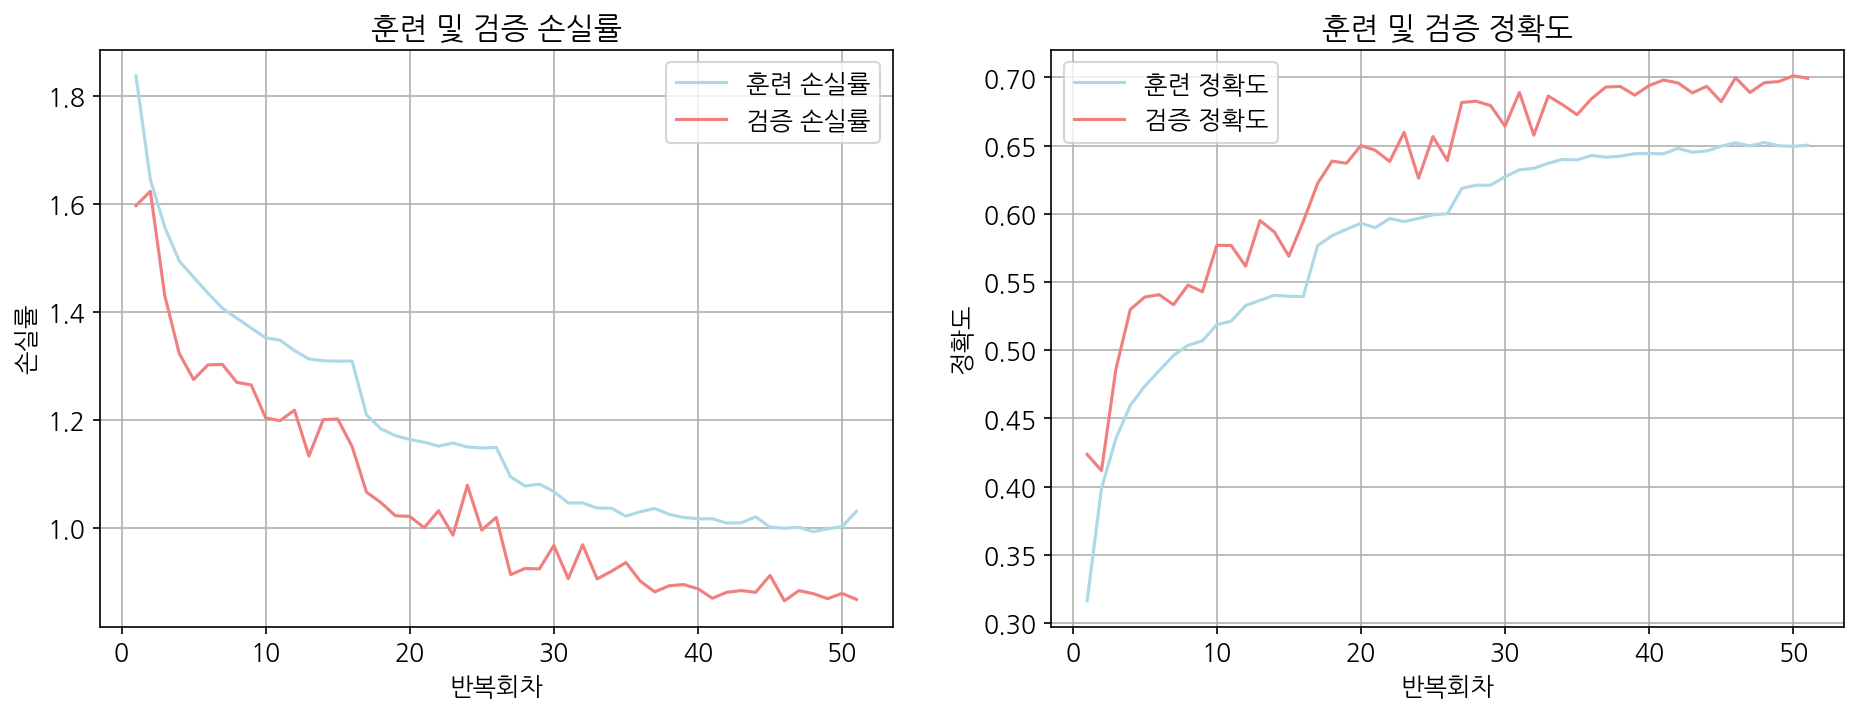

In [15]:
# 그래프 기본설정
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
sb.lineplot(x=result_df.index,
            y='loss',
            data=result_df,
            color='lightblue',
            label='훈련 손실률',
            ax=ax1)
sb.lineplot(x=result_df.index,
            y='val_loss',
            data=result_df,
            color='lightcoral',
            label='검증 손실률',
            ax = ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 정확도 그리기
sb.lineplot(x=result_df.index,
            y='acc',
            data=result_df,
            color='lightblue',
            label='훈련 정확도',
            ax=ax2)
sb.lineplot(x=result_df.index,
            y='val_acc',
            data=result_df,
            color='lightcoral',
            label='검증 정확도',
            ax=ax2)
ax2.set_title('훈련 및 검증 정확도')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

In [16]:
evaluate1 = my_model.evaluate(train_set)
print('최종 훈련 손실률: %f, 최종 훈련 정확도: %f' % (evaluate1[0], evaluate1[1]))
evaluate2 = my_model.evaluate(test_set)
print('최종 검증 손실률: %f, 최종 검증 정확도: %f' % (evaluate2[0], evaluate2[1]))

10000/10000 [==============================] - 52s 5ms/step - loss: 0.7552 - acc: 0.7395
최종 훈련 손실률: 0.755192, 최종 훈련 정확도: 0.739520
2000/2000 [==============================] - 11s 5ms/step - loss: 0.8679 - acc: 0.6993
최종 검증 손실률: 0.867873, 최종 검증 정확도: 0.699300


## 7. 학습 결과 적용
### 1) 훈련 데이터에 대한 예측 결과 산정

In [19]:
pred = my_model.predict(train_set)
data_count, case_count = pred.shape
print('%d개의 훈련 데이터가 %d개의 경우의 수를 갖는다' % (data_count, case_count))
pred[0]


10000/10000 [==============================] - 44s 4ms/step
50000개의 훈련 데이터가 10개의 경우의 수를 갖는다


array([1.2239828e-02, 5.8130192e-04, 1.1799835e-02, 4.7121845e-02,
       5.8222399e-04, 1.3513373e-04, 1.5938233e-04, 9.2091537e-01,
       6.3709929e-03, 9.4132745e-05], dtype=float32)

### 2) 가장 큰 확률 값의 인덱스를 별도 리스트로 추출

In [20]:
pred_result = np.argmax(pred, axis=-1)
pred_result

array([7, 6, 8, ..., 0, 6, 6])

## 3) 각 종속변수별로 레이블링이 어떻게 되어 있는지 확인

In [21]:
class_names = list(train_set.class_indices.keys())
class_names

['dog',
 'truck',
 'bird',
 'cat',
 'automobile',
 'airplane',
 'horse',
 'frog',
 'deer',
 'ship']

In [22]:
img, label = train_set[0]
label

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

### 4) 훈련용 이미지에 대한 예측 결과 확인

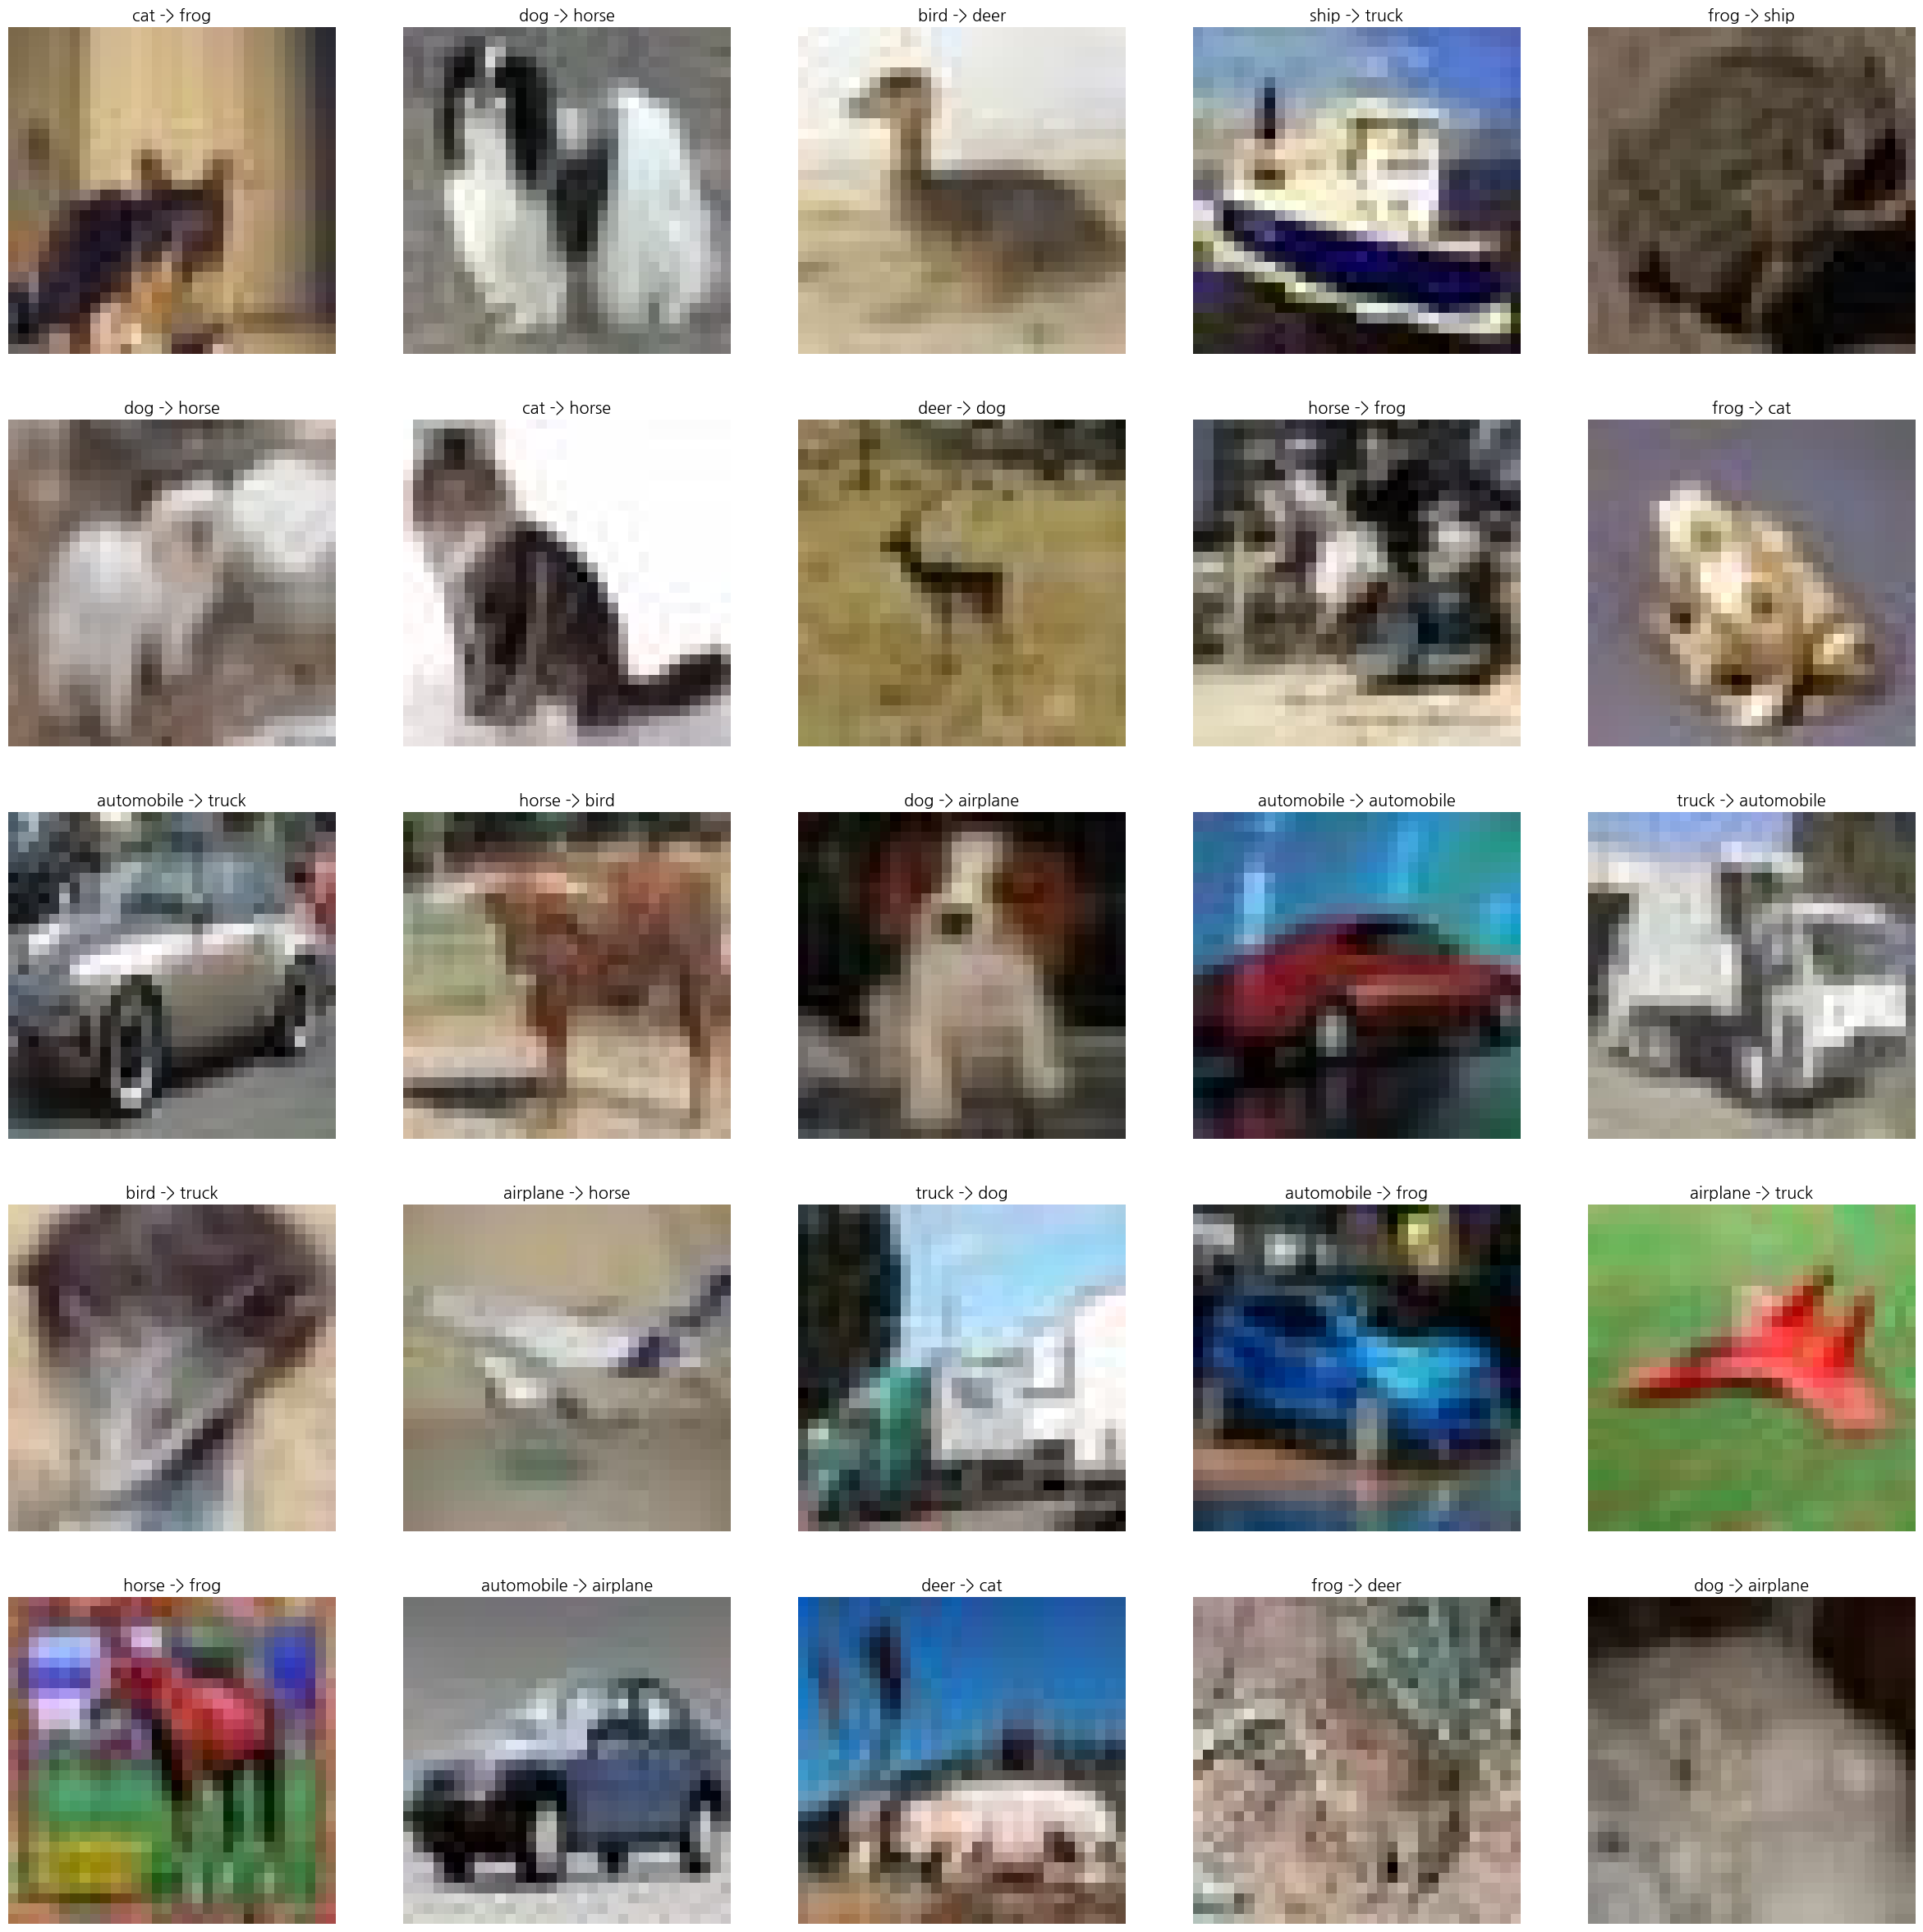

In [27]:
row = 5           # 내가 몇 줄을 출력하고 싶은지 지정
col = train_set.batch_size # batch-size에 맞춰서 지정 (값이 너무 클 경우 반복문 로직을 따로 적용)
fig, ax = plt.subplots(row, col, figsize = ((col+1)*5, (row+1)*5))

k = 0

for i in range(0, row):
    # batch_size만큼의 첫 번째 이미지 묶음을 반환
    # -> image와 label의 길이는 col과 동일하다
    img, label = train_set[i]
    for j in range(0, col):
      # 종속변수인 label을 one-hot-encoding 형태도 반환되므로 몇 번째 인덱스가 '1'인지 찾아야 한다
      label_max = np.argmax(label[j], axis=-1)
      ax[i][j].imshow(img[j])
      ax[i][j].set_title("%s -> %s" % (class_names[label_max], class_names[pred_result[k]]))
      ax[i][j].axis('off')
      k += 1

plt.show()
plt.close()

### 5) 혼돈 행렬

In [28]:
train_set.labels

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [29]:
cm = confusion_matrix(train_set.labels, pred_result)
cmdf2 = DataFrame(cm,
                  columns=list(map(lambda x: '(r)%s' % class_names[x],
                                   range(10))),
                  index=list(map(lambda x: '(p)%s' % class_names[x],
                                 range(10))))
cmdf2

,(r)dog,(r)truck,(r)bird,(r)cat,(r)automobile,(r)airplane,(r)horse,(r)frog,(r)deer,(r)ship
(p)dog,396,493,387,453,497,454,543,564,670,543
(p)truck,400,504,387,462,482,492,485,545,701,542
(p)bird,408,483,402,442,485,468,531,550,655,576
(p)cat,387,456,393,470,504,514,540,553,648,535
(p)automobile,422,512,372,445,503,492,522,545,651,536
(p)airplane,424,497,401,480,504,451,528,543,652,520
(p)horse,388,490,382,505,511,479,531,530,689,495
(p)frog,387,526,389,488,518,489,502,527,636,538
(p)deer,399,474,407,468,475,522,530,556,647,522
(p)ship,405,467,407,467,503,506,528,518,650,549


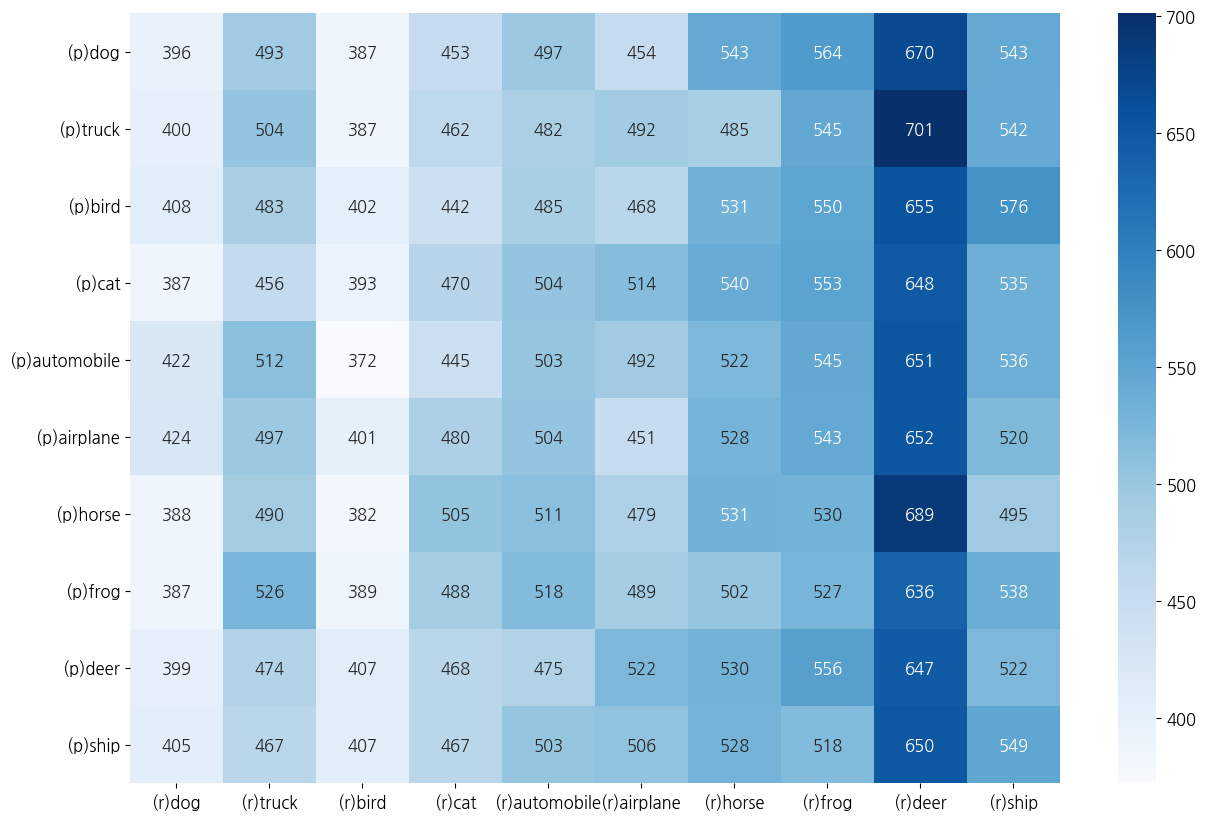

In [30]:
plt.figure(figsize=(15, 10))
sb.heatmap(cmdf2, annot=True, fmt='d', cmap='Blues')
plt.show()
plt.close()